<a href="https://colab.research.google.com/github/msapurva/Sorting-arrays-using-Pointer_Networks_w_Fast_Weights/blob/master/Sorting_using_Pointer_Networks_w_Fast_Weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from datetime import datetime as dt

In [0]:
tf.enable_eager_execution()
np.random.seed(42)
tf.random.set_random_seed(42)

### Experiment Configuration

In [26]:
hidden_dimensions=128 # epoch configuration defined later below

minSeqSize=3
maxSeqSize=5

batchSize=32
numOfBatches=150
datasize=batchSize*numOfBatches*(maxSeqSize-minSeqSize+1)

datasize


14400

### Dataset Preparation

In [0]:
def makeData(minSeqSize,maxSeqSize,batchSize,numOfBatches):
    X={}
    Y={}
    datasize=batchSize*numOfBatches*(maxSeqSize-minSeqSize+1)

    for seqLen in range(minSeqSize,maxSeqSize+1):
        X[seqLen]=[]
        Y[seqLen]=[]

        for dataidx in range(int(datasize/(maxSeqSize-minSeqSize+1))):
            seqBase=np.random.uniform(size=(seqLen))
            aSeq=seqBase
            X[seqLen]+=[aSeq]
            
            # Y
            aRec=[]
            for e in np.sort(seqBase):
                idx=list(seqBase).index(e)
                aRec+=[np.zeros(seqLen,dtype=np.float32)]
                aRec[-1][idx]=1
            Y[seqLen]+=[aRec]

        X[seqLen]=np.array(X[seqLen],dtype=np.float32)
        X[seqLen]=np.reshape(X[seqLen],[X[seqLen].shape[0],X[seqLen].shape[1],1])
        Y[seqLen]=np.array(Y[seqLen],dtype=np.float32)
    return X,Y

In [0]:
trainX,trainY=makeData(minSeqSize,maxSeqSize,batchSize,numOfBatches)

In [29]:
print('Train X for',minSeqSize,':',trainX[minSeqSize].shape)
print('Train Y for',minSeqSize,':',trainY[minSeqSize].shape)

Train X for 3 : (4800, 3, 1)
Train Y for 3 : (4800, 3, 3)


In [30]:
trainX[4][0]

array([[0.03815361],
       [0.4298177 ],
       [0.06307518],
       [0.789144  ]], dtype=float32)

In [31]:
trainY[4][0]

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

### Pointer Network with Fast Weights

In [0]:
class FastWeightsCell(tf.keras.Model):
    def __init__(self,features=1, output_size=1,decay_rate = 0.9, learning_rate = 0.5, hidden_size=50):
        super(FastWeightsCell, self).__init__()
        self.DR = decay_rate
        self.LR = learning_rate
        self.features=features
        self.output_size=output_size
        self.hidden_size = hidden_size

        
        self.W_x = tf.Variable(tf.random_uniform([self.hidden_size,self.features], -np.sqrt(2/self.features), np.sqrt(2/self.features)), dtype=tf.float32)
        self.B_x = tf.Variable(tf.zeros([self.hidden_size,1]), dtype=tf.float32)
        self.W_h = tf.Variable(initial_value = 0.5 * np.identity(self.hidden_size), dtype = tf.float32)
        self.W_y = tf.Variable(tf.random_uniform([self.output_size,self.hidden_size], -np.sqrt(2/self.hidden_size), np.sqrt(2/self.hidden_size)), dtype = tf.float32)
        self.B_y = tf.Variable(tf.zeros([self.output_size,1]), dtype= tf.float32)
        self.scale = tf.Variable(tf.ones([1,self.hidden_size,1]), dtype = tf.float32) 
        self.shift = tf.Variable(tf.zeros([1,self.hidden_size,1]), dtype = tf.float32)
        
        # values of A and H matricies
        self.A = None  
        self.H = None  

    def call(self,X,H,A,S=1):

        X = tf.cast(X, tf.float32)
        self.H=H
        self.A=A

        # --- get new A ----
        self.A = tf.scalar_mul(self.DR, self.A) + tf.scalar_mul(self.LR,(tf.matmul(H, tf.transpose(H,perm=[0,2,1]))))

        broad_W_h=tf.broadcast_to(self.W_h,[self.H.shape[0].value,self.W_h.shape[0].value,self.W_h.shape[1].value])
        broad_W_x=tf.broadcast_to(self.W_x,[self.H.shape[0].value,self.W_x.shape[0].value,self.W_x.shape[1].value])
        H_s=tf.nn.relu(tf.matmul(broad_W_h,self.H)+tf.matmul(broad_W_x,X)        +     tf.expand_dims(self.B_x,0))


        # --- get H_(s!=0) using W, previous_H, new A, H_s previous and applying normalization ---
        for _ in range(S):
            H_s=         tf.matmul(self.A,H_s)  +    tf.matmul(broad_W_h,self.H) + tf.matmul(broad_W_x,X)  +  tf.expand_dims(self.B_x,0)
                    
            # applying Layer Normalization 
            mean, var = tf.nn.moments(H_s, axes =0, keep_dims = True)
            H_s = (self.scale*(H_s - mean))/(tf.sqrt(var + 1e-5) + self.shift)
            
            # applying non linearity
            H_s = tf.nn.relu(H_s)
        
        self.H = H_s
        broad_W_y=tf.broadcast_to(self.W_y,[self.H.shape[0].value,self.W_y.shape[0].value,self.W_y.shape[1].value])
        output = tf.matmul(broad_W_y,self.H) + tf.expand_dims(self.B_y,0)

        # --- return output, hidden state, and value of matrix A ---
        return output, self.H, self.A

In [0]:
class FWPointerNetwork(tf.keras.Model):
    def __init__(self,features=1, output_size=None, hidden_size=50, fw_x_size=None, attentionInternalDim=None):
        super(FWPointerNetwork, self).__init__()
        self.features = features
        self.output_size=output_size
        if self.output_size is None:
            self.output_size=features
        self.hidden_size = hidden_size
        self.attentionInternalDim=attentionInternalDim
        if self.attentionInternalDim is None:
            self.attentionInternalDim=self.hidden_size
        self.fw_x_size=fw_x_size
        if self.fw_x_size is None:
            self.fw_x_size=self.hidden_size

        # Encoder and Encoder Input
        self.encodercell = FastWeightsCell(features=self.fw_x_size, output_size=self.output_size,hidden_size=self.hidden_size)
        self.W_e = tf.Variable(tf.random_uniform([self.fw_x_size, self.features], -0.08, 0.08), dtype=tf.float32)    
        self.B_e = tf.Variable(tf.random_uniform([self.fw_x_size, 1], -0.08, 0.08), dtype=tf.float32)

        # Decoder and Decoder Input
        self.decodercell = FastWeightsCell(features=self.fw_x_size, output_size=self.output_size,hidden_size=self.hidden_size)
        self.W_d = tf.Variable(tf.random_uniform([self.fw_x_size, self.features], -0.08, 0.08), dtype=tf.float32)    
        self.B_d = tf.Variable(tf.random_uniform([self.fw_x_size, 1], -0.08, 0.08), dtype=tf.float32)

        # Attention Related Vector with bias
        self.W1 = tf.Variable(tf.random_uniform([self.attentionInternalDim,self.hidden_size], -0.08, 0.08), dtype=tf.float32)
        self.W2 = tf.Variable(tf.random_uniform([self.attentionInternalDim,self.hidden_size], -0.08, 0.08), dtype=tf.float32)
        self.V = tf.Variable(tf.random_uniform([self.attentionInternalDim, 1], -0.5, 0.5), dtype=tf.float32)
        self.B_ptr = tf.Variable(tf.random_uniform([self.attentionInternalDim,1], -0.08, 0.08), dtype=tf.float32)


    def call(self, X):
        givenbatchsize=X.shape[0].value
        givenSeqLen=X.shape[1].value
        eHstates = []
        eH = tf.zeros([givenbatchsize, self.hidden_size,1],dtype=np.float32)
        eA = tf.zeros([givenbatchsize, self.hidden_size,self.hidden_size],dtype=np.float32)
        for i in range(givenSeqLen):            
            # get batch's ith time step input
            X_i = tf.transpose(X[:,i:i+1],[0,2,1])
            broad_W_e=tf.broadcast_to(self.W_e,[givenbatchsize,self.W_e.shape[0].value,self.W_e.shape[1].value])
            cell_input = tf.nn.elu(tf.matmul(broad_W_e,X_i) + tf.expand_dims(self.B_e,0))
            _, eH,        eA        = self.encodercell(cell_input, eH, eA)
            eHstates.append(eH)

        dH = eHstates[-1]
        dA = tf.zeros([givenbatchsize, self.hidden_size,self.hidden_size],dtype=np.float32)
        X_i = tf.constant(-1,dtype=np.float32,shape=[givenbatchsize,self.features,1])
        attentionVector_all=None
        outputVector_all=None
        identity=tf.eye(givenSeqLen,dtype=np.float32)
        
        for i in range(givenSeqLen):
            
            # -- apply the encoder dense layer to the batch --

            broad_W_d=tf.broadcast_to(self.W_d,[givenbatchsize,self.W_d.shape[0].value,self.W_d.shape[1].value])

            cell_input = tf.nn.elu(tf.matmul(broad_W_d,X_i) + tf.expand_dims(self.B_d,0))

            _, dH,        dA        = self.decodercell(cell_input, dH, dA)
            
            # -- get the attention vector --
            broad_W1 = tf.broadcast_to(self.W1,[givenbatchsize,self.W1.shape[0].value,self.W1.shape[1].value])            
            broad_W2 = tf.broadcast_to(self.W2,[givenbatchsize,self.W2.shape[0].value,self.W2.shape[1].value])
            broad_V = tf.broadcast_to(self.V,[givenbatchsize,self.V.shape[0].value,self.V.shape[1].value])
            # get the decoder part of attention equation
            d_part=tf.matmul(broad_W2,dH)            
            # attention vector
            attentionVector_i=None
            
            # components of attention vector based on components encoder
            for encoderIndex in range(givenSeqLen):

                attentionVector_component=tf.matmul(broad_W1,eHstates[encoderIndex])+ d_part     + tf.expand_dims(self.B_ptr,0)
                attentionVector_component=tf.nn.elu(attentionVector_component)
                attentionVector_component=tf.matmul(tf.transpose(broad_V,perm=[0,2,1]),attentionVector_component)
                if attentionVector_i is None:
                    attentionVector_i=attentionVector_component
                else:
                    attentionVector_i=tf.concat([attentionVector_i,attentionVector_component],axis=2)
            attentionVector_i=tf.nn.softmax(attentionVector_i,axis=2)
            
            # overall attention vector for the batch x seqLen
            if attentionVector_all is None:
                attentionVector_all=attentionVector_i
            else:
                attentionVector_all=tf.concat(       [attentionVector_all  ,   attentionVector_i   ],axis=1)
            
            predictedOutput_i  =   tf.cast(tf.argmax(attentionVector_i,axis=2),dtype=np.int32)
            extractionMatrix=tf.nn.embedding_lookup(identity,tf.reshape(predictedOutput_i,[predictedOutput_i.shape[0]]))
            extractionMatrix=tf.expand_dims(extractionMatrix,axis=1)
            X_i=tf.matmul(  tf.cast(extractionMatrix,dtype=np.float32) ,      X   )
            if outputVector_all is None:
                outputVector_all=X_i
            else:
                outputVector_all=tf.concat([outputVector_all,X_i],axis=1)
            X_i=tf.transpose(X_i,[0,2,1])
            # b x f x 1


        return attentionVector_all,outputVector_all 

In [0]:
def runAndGetLoss(X,Y,model,isVerbose=0):

    attn,output=model(X)
    loss=tf.reduce_mean(tf.keras.backend.categorical_crossentropy(Y, attn))
    loss=(loss/float(maxSeqSize-minSeqSize+1))
    
    if isVerbose>0:
      for instance_idx in range(X.shape[0]):
        print("====== Actual :",np.reshape(X[instance_idx],X[instance_idx].shape[0]))
        print('  - Predicted :',np.reshape(output[instance_idx],output[instance_idx].shape[0]))
        print('\n\n')
    
    return attn,output,loss



### Instantiate the Network

In [0]:
fwpn = FWPointerNetwork(features=trainX[minSeqSize][0].shape[1], output_size=trainX[minSeqSize][0].shape[1], hidden_size=hidden_dimensions)

### Output of Network Before Training

In [36]:
# Use data point
seqLen=minSeqSize
attn,output,aloss=runAndGetLoss(trainX[seqLen][0:batchSize],trainY[seqLen][0:batchSize],fwpn,1)
print("loss:",aloss)
print("attn:")
print(attn)

====== Actual : [0.37454012 0.9507143  0.7319939 ]
  - Predicted : [0.9507143 0.9507143 0.9507143]



====== Actual : [0.5986585  0.15601864 0.15599452]
  - Predicted : [0.15601864 0.15601864 0.15601864]



====== Actual : [0.05808361 0.8661761  0.601115  ]
  - Predicted : [0.05808361 0.05808361 0.05808361]



====== Actual : [0.7080726  0.02058449 0.96990985]
  - Predicted : [0.96990985 0.96990985 0.96990985]



====== Actual : [0.83244264 0.21233912 0.18182497]
  - Predicted : [0.18182497 0.18182497 0.18182497]



====== Actual : [0.1834045  0.30424225 0.52475643]
  - Predicted : [0.52475643 0.52475643 0.52475643]



====== Actual : [0.43194503 0.29122913 0.6118529 ]
  - Predicted : [0.29122913 0.29122913 0.29122913]



====== Actual : [0.13949387 0.29214466 0.36636186]
  - Predicted : [0.36636186 0.36636186 0.36636186]



====== Actual : [0.45606998 0.785176   0.19967379]
  - Predicted : [0.785176 0.785176 0.785176]



====== Actual : [0.5142344  0.59241456 0.04645041]
  - Predicted

### Model Training

##### Config Training

In [0]:
# create batches of training data
batchedDataset={}
for seqLen in range(minSeqSize,maxSeqSize+1):
    batchedDataset[seqLen]=[]
    for aBatch in tf.data.Dataset.from_tensor_slices((trainX[seqLen],trainY[seqLen])).batch(batchSize):
        batchedDataset[seqLen]+=[aBatch]

In [0]:
# create dev data and batches
devBatchSize=64
devX,devY=makeData(minSeqSize,maxSeqSize,devBatchSize,1)

In [0]:
# training configuration
lastepoch=-1
optimizer = tf.train.AdamOptimizer()
loss_history = []
wholeLoss_history=[]
devLoss_history=[]
total_attention = []

##### Run Training

In [0]:
epochsToRun = 5
overfitFlag=False

In [41]:
for epoch in range(lastepoch+1,lastepoch+1+epochsToRun):
    if overfitFlag:
        break
    lastepoch=epoch
    print("New Epoch Started:",epoch)
    for batch in range(numOfBatches):
        wholeLoss=0
        for seqLen in range(minSeqSize,maxSeqSize+1):

            with tf.GradientTape() as tape:
                # get data for this batch
                input_data, target_data=batchedDataset[seqLen][batch]
                # input_data -> (batch_size, input_sequence_length, input_dimension)
                # target_data -> (batch_size, input_sequence_length, input_sequence_length)

                # run the pointer network and get loss
                _,_,batch_loss=runAndGetLoss(input_data,target_data,fwpn)
            
            # fetch the trainable variables
            variables = fwpn.variables
            
            # calculate the gradient
            grads = tape.gradient(batch_loss, variables)
                        
            # update the weights of the network
            optimizer.apply_gradients(zip(grads, variables), global_step=tf.train.get_or_create_global_step())
            
            # store the loss history 
            loss_history.append(batch_loss.numpy())

            # combined loss per output across batches of ALL seq sizes
            wholeLoss+=batch_loss/float(maxSeqSize-minSeqSize+1)

        # store the loss history 
        wholeLoss_history.append(wholeLoss.numpy())
            
        if batch % 10 == 0:
            print("\tEpoch {:03d}/{:03d}: Loss at batchSetNum {:02d}: {:.9f}".format((epoch), epochsToRun-1, batch, wholeLoss),dt.now())

            devLoss=0
            for seqLen in range(minSeqSize,maxSeqSize+1):
                _,_,interdevLoss=runAndGetLoss(devX[seqLen],devY[seqLen],fwpn)
                devLoss+=interdevLoss/float(maxSeqSize-minSeqSize+1)
            devLoss_history.append(devLoss.numpy())
            print('\t               WholeLoss:',np.round(wholeLoss.numpy(),5),'DevLoss:',np.round(devLoss,5))

    print("Epoch {:03d}/{:03d} completed \t - \tLoss at batchSetNum {:02d}: {:.9f}".format((epoch), epochsToRun-1, batch, wholeLoss),dt.now())
print("Final loss: {:.9f}".format(wholeLoss),dt.now())

New Epoch Started: 0
	Epoch 000/004: Loss at batchSetNum 00: 0.494494259 2019-05-04 20:50:22.469190
	               WholeLoss: 0.49449 DevLoss: 0.47204
	Epoch 000/004: Loss at batchSetNum 10: 0.454814970 2019-05-04 20:50:26.381139
	               WholeLoss: 0.45481 DevLoss: 0.45486
	Epoch 000/004: Loss at batchSetNum 20: 0.454199016 2019-05-04 20:50:30.111482
	               WholeLoss: 0.4542 DevLoss: 0.45477
	Epoch 000/004: Loss at batchSetNum 30: 0.454629600 2019-05-04 20:50:33.863497
	               WholeLoss: 0.45463 DevLoss: 0.4543
	Epoch 000/004: Loss at batchSetNum 40: 0.454117119 2019-05-04 20:50:37.601897
	               WholeLoss: 0.45412 DevLoss: 0.45562
	Epoch 000/004: Loss at batchSetNum 50: 0.471841991 2019-05-04 20:50:41.348765
	               WholeLoss: 0.47184 DevLoss: 0.46477
	Epoch 000/004: Loss at batchSetNum 60: 0.455596745 2019-05-04 20:50:45.103969
	               WholeLoss: 0.4556 DevLoss: 0.45495
	Epoch 000/004: Loss at batchSetNum 70: 0.454259902 2019-05-04 20

### Loss plot over the entire training sequence

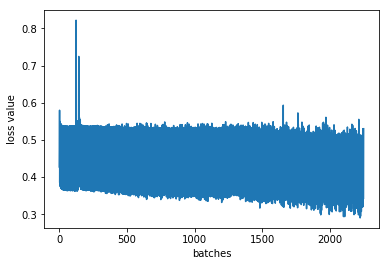

In [42]:
plt.plot(loss_history)
plt.ylabel('loss value')
plt.xlabel('batches')
plt.show()

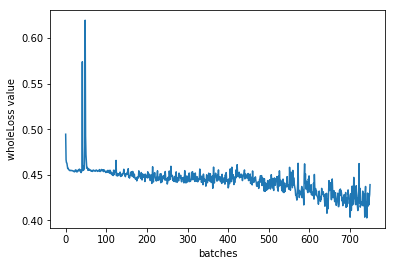

In [43]:
plt.plot(wholeLoss_history)
plt.ylabel('wholeLoss value')
plt.xlabel('batches')
plt.show()

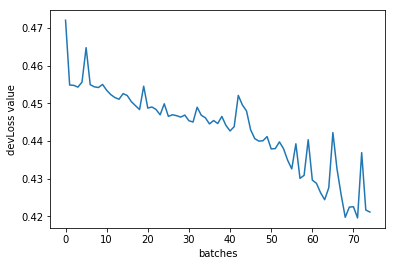

In [44]:
plt.plot(devLoss_history)
plt.ylabel('devLoss value')
plt.xlabel('batches')
plt.show()

### Inference

In [45]:
# print 1
aloss=0
print("SUMMARY")
for seqLen in range(minSeqSize,maxSeqSize+1+5):
  if seqLen==maxSeqSize+1:
    print('---')
  X,Y=makeData(seqLen,seqLen,50,1)
  _,_,interdevLoss=runAndGetLoss(X[seqLen],Y[seqLen],fwpn)
  aloss+=interdevLoss/float(maxSeqSize-minSeqSize+1)
  print('Seq:',seqLen,'Size:',X[seqLen].shape[0],'loss:',aloss.numpy())


SUMMARY
Seq: 3 Size: 50 loss: 0.11700639
Seq: 4 Size: 50 loss: 0.25899863
Seq: 5 Size: 50 loss: 0.42547652
---
Seq: 6 Size: 50 loss: 0.61819184
Seq: 7 Size: 50 loss: 0.8349714
Seq: 8 Size: 50 loss: 1.0666623
Seq: 9 Size: 50 loss: 1.319737
Seq: 10 Size: 50 loss: 1.5850308


In [46]:
# print 2
print("DETAILED")
for seqLen in range(minSeqSize,maxSeqSize+1+5):
  print()
  if seqLen==maxSeqSize+1:
      print('*********************************************************************************************************************************************')
  print()
  X,Y=makeData(seqLen,seqLen,50,1)
  print('Seq:',seqLen,'Size:',X[seqLen].shape[0])
  print('--------------------------------------------------------------------------------------------------------------------------------------------')
  _,_,interdevLoss=runAndGetLoss(X[seqLen],Y[seqLen],fwpn,1)
  aloss+=interdevLoss/float(maxSeqSize-minSeqSize+1)
  print('loss:',aloss.numpy())

DETAILED


Seq: 3 Size: 50
--------------------------------------------------------------------------------------------------------------------------------------------
====== Actual : [0.10679921 0.14326723 0.3152445 ]
  - Predicted : [0.10679921 0.14326723 0.3152445 ]



====== Actual : [0.45148468 0.1933501  0.755625  ]
  - Predicted : [0.755625   0.45148468 0.45148468]



====== Actual : [0.19332437 0.12412645 0.9945549 ]
  - Predicted : [0.19332437 0.19332437 0.9945549 ]



====== Actual : [0.44771156 0.17000702 0.89455694]
  - Predicted : [0.89455694 0.44771156 0.44771156]



====== Actual : [0.23109162 0.92557997 0.11896085]
  - Predicted : [0.23109162 0.23109162 0.92557997]



====== Actual : [0.8418147 0.1842671 0.9383376]
  - Predicted : [0.9383376 0.9383376 0.9383376]



====== Actual : [0.57424366 0.18991369 0.8448201 ]
  - Predicted : [0.8448201 0.8448201 0.8448201]



====== Actual : [0.390576  0.7328134 0.6434407]
  - Predicted : [0.7328134 0.390576  0.6434407]



====== 